# Debug CPP Analysis

In [19]:
%pip install pandas
%pip install scipy
import json
import pandas as pd
import os
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, freqz, lfilter, lfilter_zi
from scipy.signal import find_peaks
from pathlib import Path

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
def extract_processed_data_from_csv(file_path):

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Drop any rows that are completely NaN
    df.dropna(how='all', inplace=True)
    
    # Fill or drop NaN values in specific columns as needed
    df.ffill(inplace=True)  # Forward fill for simplicity, adjust as needed
    df.dropna(inplace=True)  # Drop rows if any NaN values remain after forward fill
    
    # Ensure all numerical columns are of the correct type
    for column in df.columns:
        if column not in ['Time (ms)', 'Estimated HR (Hz)', 'Estimated HR (bpm)', 'Time to next peak (ms)', 'Heart rate pulse interval (ms)', 'Red LED ADC', 'IR LED ADC', "Filtered", "ZeroCross"]:
            continue
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # Handle any remaining NaNs if conversion resulted in them
    df.fillna(0, inplace=True)  # Fill NaNs with 0, adjust as necessary for your use case

    # Process timestamps to ensure that they are monotonically increasing
    timeColumn = df['Time (ms)']
    lastTime = timeColumn[0]
    newTimeColumn = []
    newTimeColumn.append(0)
    wrapTimeMs = 2**16
    fixTime = 0
    for i in range(1, len(timeColumn)):
        if timeColumn[i] < lastTime:
            fixTime += wrapTimeMs
            print(f"Fixing time at index {i} fixed time: {fixTime} timestamp: {timeColumn[i]} last timestamp: {lastTime}")
        newTimeColumn.append((timeColumn[i] + fixTime - timeColumn[0]) / 1000.0)
        lastTime = timeColumn[i]
    df['Time (s)'] = newTimeColumn
    return df

In [3]:
# Filter design
fs = 25.0  # Sample rate, Hz
lowcut = 0.75  # Desired low cut frequency of the filter, Hz
highcut = 3.0  # Desired high cut frequency of the filter, Hz
filter_order = 2

In [5]:
# Function to create a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [22]:
input_log_file = "20250204-112641.log"
# Process the log file to a CSV
input_file = os.path.abspath(os.path.join(os.getcwd(), "../logs", input_log_file))
log_csv_file = input_file.replace(".log", "_log.csv")
rslt = False
try:
    print(os.getcwd())
    script_path = os.path.join(os.getcwd(), "ProcLogWithHRMPollData.py")
    rslt = subprocess.run(["python3", script_path, input_file, log_csv_file], check=True)
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")
print(rslt)


/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/DebugCPPAnalysis
CSV file created: /home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/logs/20250204-112641_log.csv
CompletedProcess(args=['python3', '/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/DebugCPPAnalysis/ProcLogWithHRMPollData.py', '/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/logs/20250204-112641.log', '/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/logs/20250204-112641_log.csv'], returncode=0)


In [23]:
HRM_CPP_EXECUTABLE = Path("../HRMAnalysisCPPCLI/HRMAnalysisCPPCLI").resolve()
# print(HRM_CPP_EXECUTABLE.is_file())

# Process the log csv file using the C++ CLI
processed_csv_file = log_csv_file.replace("_log.csv", "_processed.csv")
rslt = False
try:
    rslt = subprocess.run([HRM_CPP_EXECUTABLE, log_csv_file, processed_csv_file], check=True)
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")
print(rslt)


Output written to /home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/logs/20250204-112641_processed.csv
CompletedProcess(args=[PosixPath('/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/HRMAnalysisCPPCLI/HRMAnalysisCPPCLI'), '/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/logs/20250204-112641_log.csv', '/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/logs/20250204-112641_processed.csv'], returncode=0)


In [24]:
processed_data = extract_processed_data_from_csv(processed_csv_file)
t = processed_data["Time (s)"]
hr_data = processed_data["Red LED ADC"]
cpp_filtered = processed_data["Filtered"]
zero_cross = processed_data["ZeroCross"]

Fixing time at index 704 fixed time: 65536 timestamp: 70 last timestamp: 65530


<Figure size 2000x600 with 0 Axes>

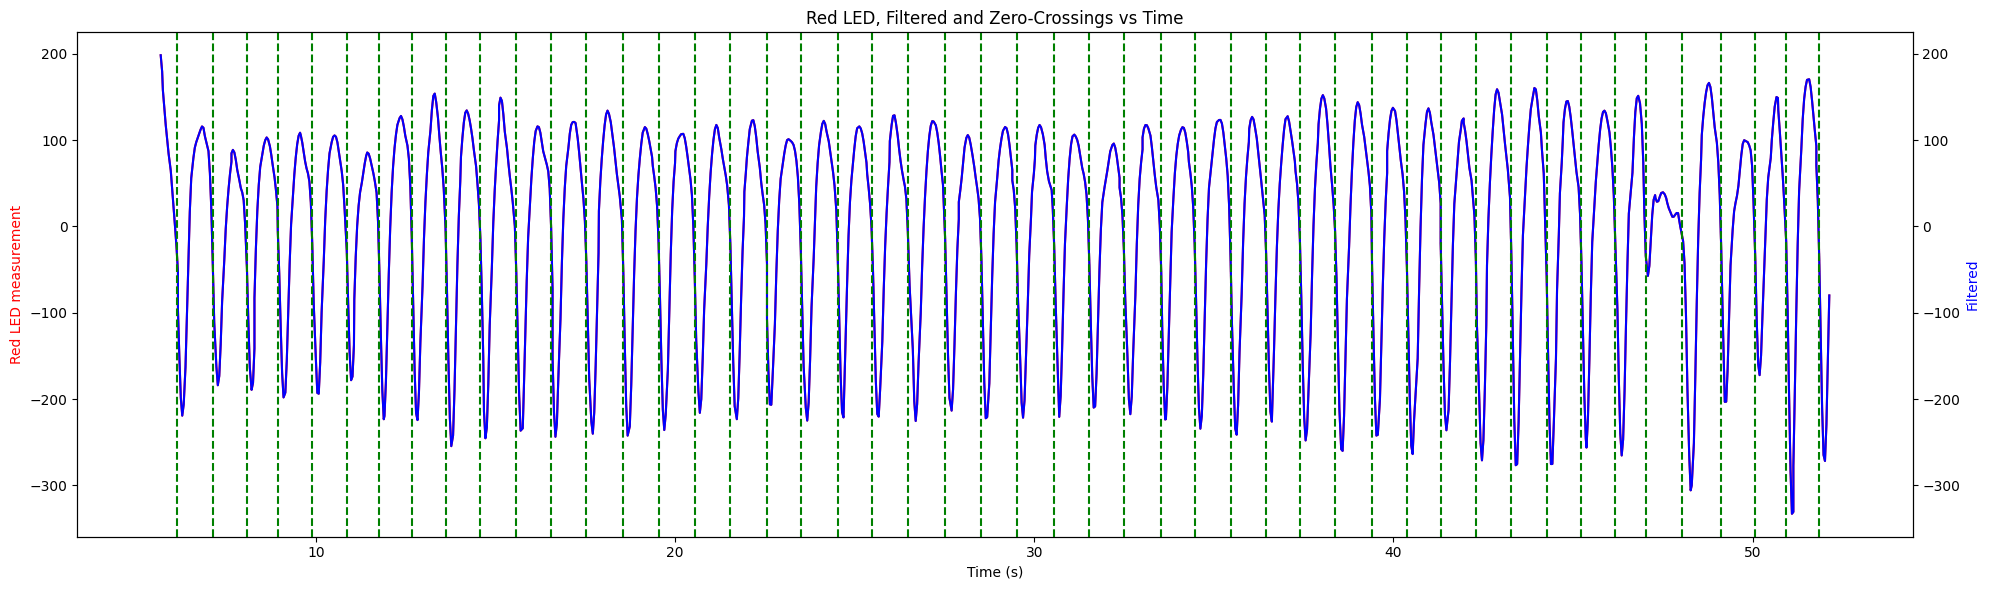

In [ ]:
# Apply the bandpass filter
py_filtered = bandpass_filter(hr_data, lowcut, highcut, fs, order=filter_order)
# print(filtered_hr_data[0:100])

# Skip initial samples
plot_start = 100
plot_end = 10000

# Plot Red ADC, filtered and zero crossing points on different Y axes
plt.figure(figsize=(20, 6))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t[plot_start:plot_end], py_filtered[plot_start:plot_end], label="PyFiltered", color='red')

for tim, zc in zip(t[plot_start:plot_end], zero_cross[plot_start:plot_end]):
    if zc != 0:
        ax2.axvline(x=tim, color='green', linestyle='--', label="ZeroCross" if first_line else "")
        first_line = False

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Red LED measurement", color='red')
ax2.set_ylabel("Filtered", color='blue')
ax1.set_title("Red LED, Filtered and Zero-Crossings vs Time")
plt.tight_layout()
plt.show()

# # Plot the original and filtered signals
# plt.figure(figsize=(20, 6))
# plt.subplot(2, 1, 1)
# plt.plot(t[plot_start:plot_end], hr_data[plot_start:plot_end], label='Original Signal')
# plt.title('Original Heart Rate Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(t[plot_start:plot_end], filtered_hr_data[plot_start:plot_end], label='Filtered Signal', color='orange')
# plt.title('Filtered Heart Rate Signal (0.8 Hz to 3.25 Hz)')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()





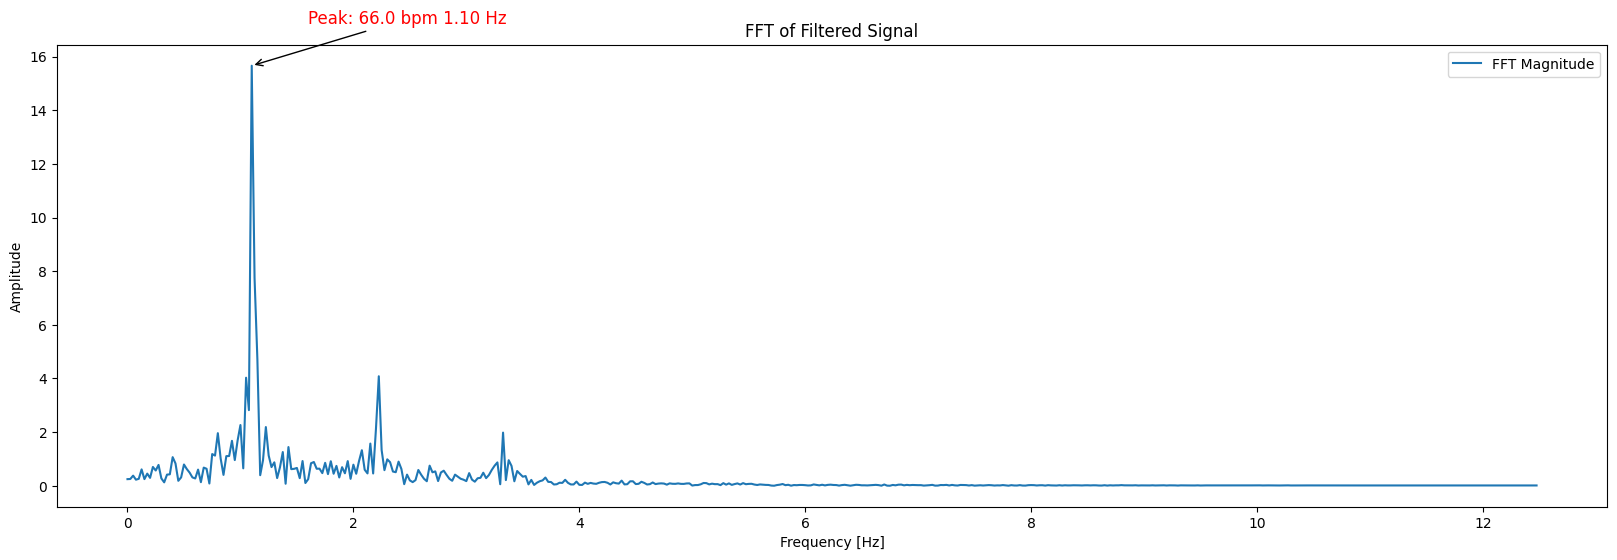

In [116]:
subset_data = cpp_filtered[plot_start:plot_end]
n = len(subset_data)
f = np.linspace(0, fs, n, endpoint=False)  # Frequency axis
Y = np.fft.fft(subset_data)

# Compute amplitude spectrum
amplitude_spectrum = np.abs(Y)[:n//2] * 1/n

# Find the peak frequency and amplitude
peak_index = np.argmax(amplitude_spectrum)
peak_freq = f[peak_index]
peak_amplitude = amplitude_spectrum[peak_index]

# Plot the FFT of the filtered signal
plt.figure(figsize=(20, 6))
plt.plot(f[:n//2], amplitude_spectrum, label="FFT Magnitude")
plt.title('FFT of Filtered Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

# Annotate the peak
plt.annotate(f'Peak: {peak_freq*60.0} bpm {peak_freq:.2f} Hz', 
             xy=(peak_freq, peak_amplitude), 
             xytext=(peak_freq + fs * 0.02, peak_amplitude * 1.1),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=12, color='red')

plt.legend()
plt.show()

In [117]:
class PIDController:
    def __init__(self, kp: float, ki: float, kd: float, max_output: float, min_output: float):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.max_output = max_output
        self.min_output = min_output
        self.integral = 0.0
        self.last_error = 0.0

    def process(self, set_point: float, process_variable: float, time_delta_ms: int) -> float:
        # Ensure time delta is valid
        if time_delta_ms <= 0:
            return 0.0

        # Calculate time in seconds
        time_delta_secs = max(time_delta_ms / 1000.0, 0.001)  # Minimum 1ms to prevent instability

        # Calculate error
        error = set_point - process_variable

        # Proportional term
        p_out = self.kp * error

        # Integral term with anti-windup
        self.integral += error * time_delta_secs
        if self.ki != 0:
            self.integral = np.clip(self.integral, self.min_output / self.ki, self.max_output / self.ki)
        i_out = self.ki * self.integral

        # Derivative term
        derivative = (error - self.last_error) / time_delta_secs if time_delta_secs > 0 else 0
        d_out = self.kd * derivative

        # Compute total output
        output = p_out + i_out + d_out

        # Clamp output within limits
        output = np.clip(output, self.min_output, self.max_output)

        # Save error for next iteration
        self.last_error = error

        return output


In [122]:
class PhaseLockedLoop:
    def __init__(self, min_freq_hz: float, max_freq_hz: float, centre_freq_hz: float,
                 max_pid_output: float, kP: float, kI: float, kD: float):
        self._frequency_pid = PIDController(kP, kI, kD, max_pid_output, -max_pid_output)
        self._max_freq_hz = max_freq_hz
        self._min_freq_hz = min_freq_hz
        self._centre_freq_hz = centre_freq_hz
        self._beat_freq_hz = centre_freq_hz  # Initialize with center frequency
        self._zero_crossing_first_ms = None
        self._last_zero_crossing_ms = None
        self._scaling_factor = 0.1  # Adjustable scaling factor
        self._last_pid_output = 0.0

    def process_zero_crossing(self, sample_time_ms: int):
        if self._zero_crossing_first_ms is None:
            self._zero_crossing_first_ms = sample_time_ms
            self._last_zero_crossing_ms = sample_time_ms
            self._beat_freq_hz = self._centre_freq_hz
            return

        if self._last_zero_crossing_ms is not None and sample_time_ms <= self._last_zero_crossing_ms + 1:
            return

        # Time between zero crossings
        interval_ms = sample_time_ms - self._last_zero_crossing_ms
        if interval_ms <= 0:
            return

        # Save last zero crossing
        self._last_zero_crossing_ms = sample_time_ms

        # Calculate frequency based on time between zero crossings
        measured_freq_hz = 1000.0 / interval_ms
        measured_freq_hz = np.clip(measured_freq_hz, self._min_freq_hz, self._max_freq_hz)

        # Update PID Controller
        self._last_pid_output = self._frequency_pid.process(self._beat_freq_hz, measured_freq_hz, interval_ms) * self._scaling_factor
        self._beat_freq_hz -= self._last_pid_output

    def time_to_next_peak_ms(self, cur_time_ms: int) -> int:
        if self._beat_freq_hz <= 0:
            return 0

        # Interval in ms between zero crossings
        interval_ms = int(1000 / self._beat_freq_hz)

        if self._last_zero_crossing_ms is None:
            return interval_ms  # Default to full interval if no crossings recorded

        # Time since last zero crossing
        time_since_last_zero_ms = cur_time_ms - self._last_zero_crossing_ms

        # Time to next zero crossing
        time_to_next_zero_ms = interval_ms - time_since_last_zero_ms

        # Time to next peak is assumed to be quarter of the interval
        time_to_next_peak_ms = (time_to_next_zero_ms + (3 * interval_ms // 4)) % interval_ms
        return time_to_next_peak_ms

    def get_beat_freq_hz(self) -> float:
        return self._beat_freq_hz
    
    def get_coeffs(self):
        return self._frequency_pid.kp, self._frequency_pid.ki, self._frequency_pid.kd
    
    def get_last_pid_output(self):
        return self._last_pid_output
    
    def get_last_error(self):
        return self._frequency_pid.last_error


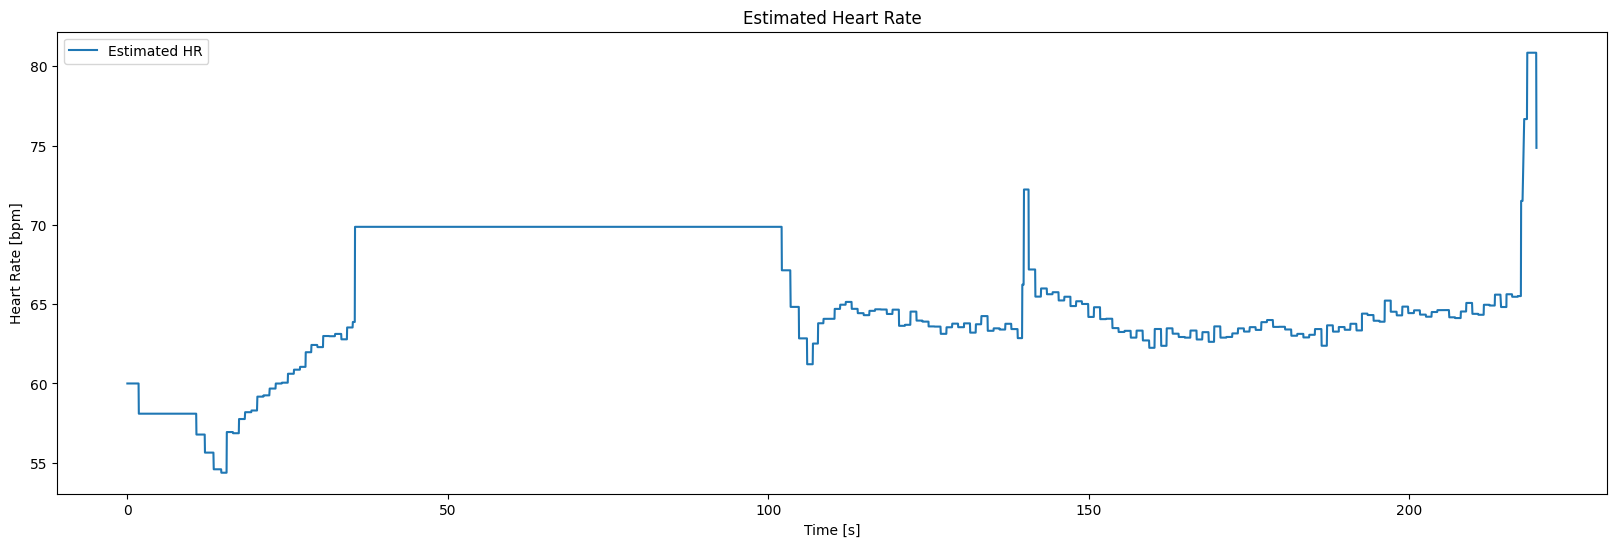

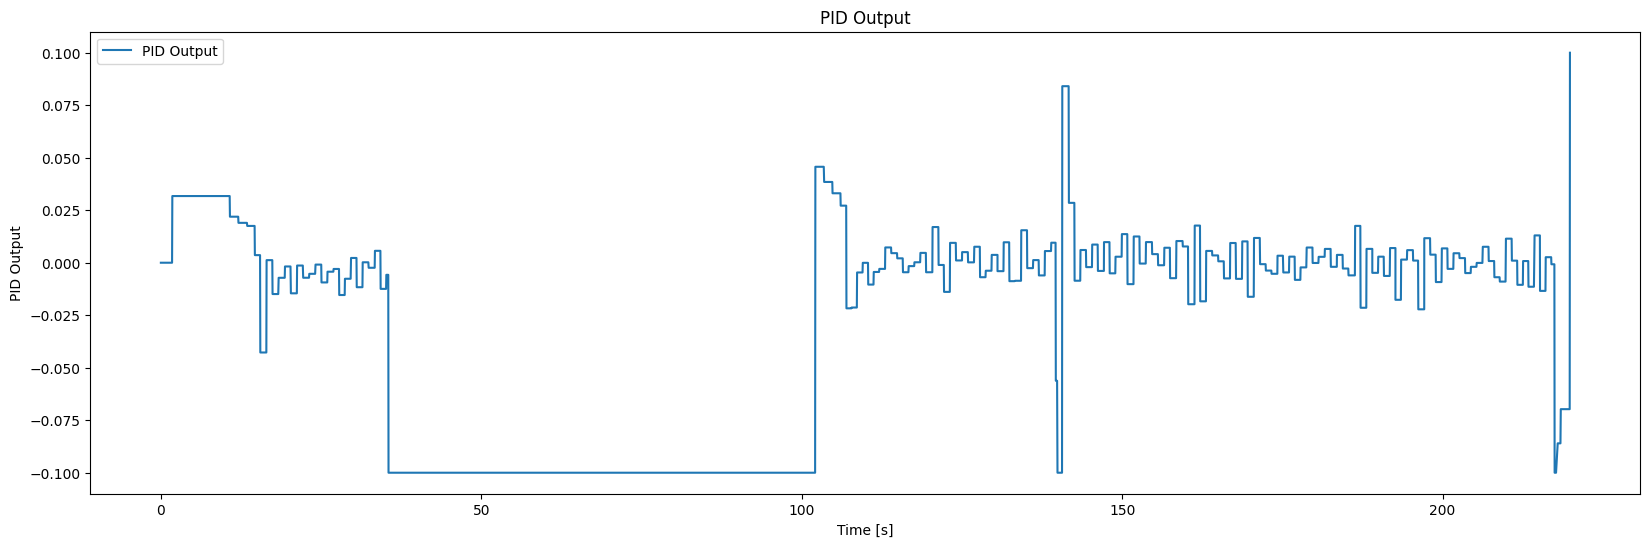

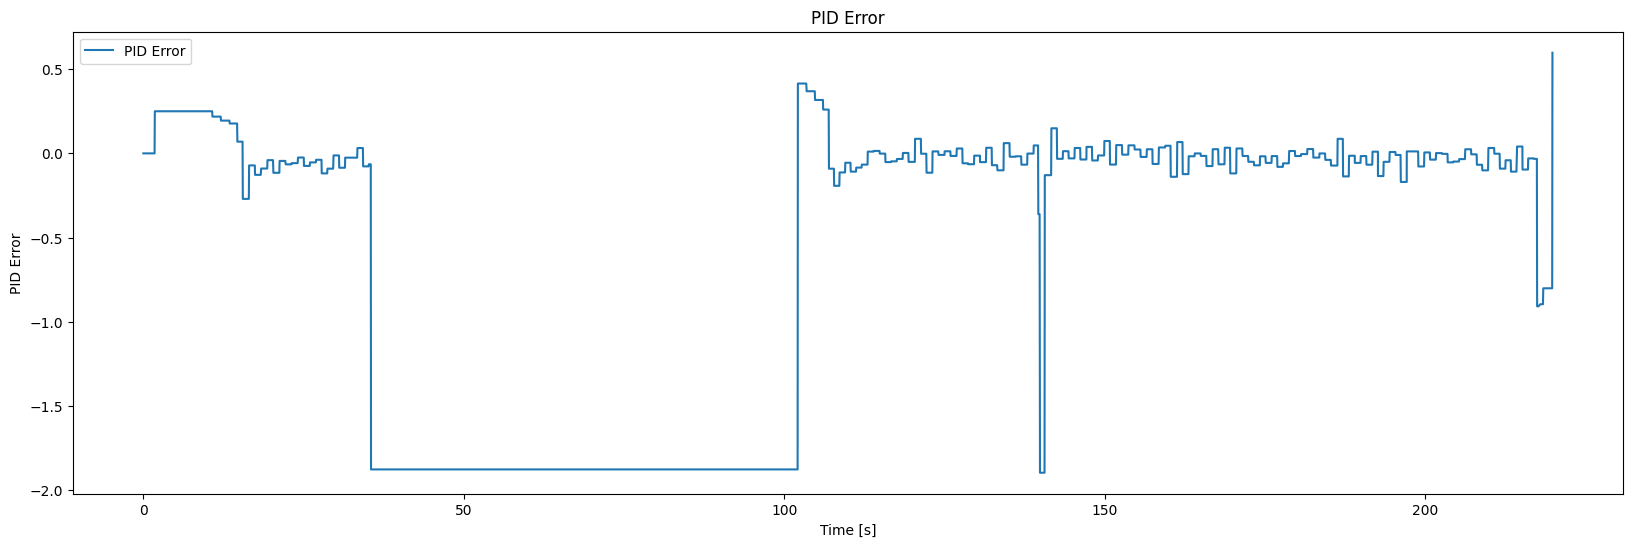

In [123]:
pll = PhaseLockedLoop(0.75, 3.0, 1.0, 1.0, 1, 0.001, 0.4)
# for i in range(plot_start, plot_end):
bpm = []
pid_output = []
pid_error = []
for i in range(len(t)):
    if zero_cross[i] != 0:
        timeMs = int(t[i] * 1000)
        pll.process_zero_crossing(timeMs)
    bpm.append(pll.get_beat_freq_hz() * 60.0)
    pid_output.append(pll.get_last_pid_output())
    pid_error.append(pll.get_last_error())

# Plot the estimated heart rate
plt.figure(figsize=(20, 6))
plt.plot(t, bpm, label='Estimated HR')
plt.title('Estimated Heart Rate')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.show()

# Plot the PID output
plt.figure(figsize=(20, 6))
plt.plot(t, pid_output, label='PID Output')
plt.title('PID Output')
plt.xlabel('Time [s]')
plt.ylabel('PID Output')
plt.legend()
plt.show()

# Plot the PID error
plt.figure(figsize=(20, 6))
plt.plot(t, pid_error, label='PID Error')
plt.title('PID Error')
plt.xlabel('Time [s]')
plt.ylabel('PID Error')
plt.legend()
plt.show()

